# Advance Implementation Notebook
Use an advanced Deep Learning approach -  Stacked Denoising Autoencoder (SDA) - to classify the images

##### Imports

In [ ]:
# General
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset
from google.colab import drive  

# Warnings
import warnings

# Deep Learning 
import torch
import torchvision
import tensorflow.keras

# DL model
import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.layers import LeakyReLU, BatchNormalization
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.models import Model

##### Hide Warnings

In [ ]:
warnings.filterwarnings('ignore')

##### Disable Autoscrolling

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Access To Dataset

In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 

data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/DeepLearning/FinalProject/data/'
data_dir

In [ ]:
os.listdir(data_dir)

['data_to_test.csv',
 'data_to_val.csv',
 'data_to_tra.csv',
 'category_and_image_downscaled_data.zip']

##### Loading dataset

In [ ]:
df = pd.read_csv(data_dir + 'category_and_image_downscaled_data.zip', compression="zip")
df.shape

(142480, 2327)

##### Create Dataframes - Train,Val,Test (60%, 20%, 20%)

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=42)
df_train.shape, df_valid.shape, df_test.shape

((85488, 2327), (28496, 2327), (28496, 2327))

In [ ]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,set_id,set_views,set_likes,date,set_name,desc,number_of_items,days_since_post,items_likes,set_price,index,item_name,item_price,item_likes,image,categoryid,category_name,categorytype_id,categorytype,category,num items,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
116992,116992,116992,133123655,4428,127,Two years,Untitled #90,#emmyfashion #emmyawards,5,730.0,10384,6152.0,2,charlotte olympia purple pink python leather m...,478.0,103,/content/drive/My Drive/data/images_clean/1331...,43,Pumps,4,shoes,Pumps,4113,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,247.0,247.0,217.0,248.0,248.0,...,248.0,248.0,248.0,248.0,248.0,247.0,246.0,245.0,245.0,245.0,243.0,243.0,243.0,245.0,245.0,245.0,245.0,243.0,246.0,244.0,243.0,245.0,245.0,246.0,245.0,245.0,246.0,246.0,246.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0
3333,3333,3333,191172477,1226,234,One year,Yoins Dress,A fashion look from February 2016 by ludmyla-s...,8,365.0,5891,7553.0,3,yoins yoins pointed heel shoes,29.0,120,/content/drive/My Drive/data/images_clean/1911...,43,Pumps,4,shoes,Pumps,4113,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,253.0,254.0,251.0,245.0,239.0,235.0,238.0,244.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
39379,39379,39379,210471729,11092,600,Three months,Wide Leg Jeans,A fashion look from October 2016 by jiabao-kro...,8,90.0,8034,2129.0,2,gucci garden exclusive denim pant,1300.0,1742,/content/drive/My Drive/data/images_clean/2104...,27,Jeans,3,bottoms,Jeans,929,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,253.0,249.0,249.0,248.0,250.0,247.0,230.0,228.0,...,250.0,248.0,246.0,239.0,238.0,237.0,238.0,236.0,237.0,237.0,241.0,245.0,252.0,255.0,254.0,255.0,255.0,254.0,253.0,252.0,252.0,253.0,249.0,244.0,243.0,241.0,240.0,239.0,241.0,245.0,250.0,251.0,254.0,255.0,254.0,254.0,254.0,255.0,255.0,255.0
56306,56306,56306,202239088,453,71,7 months,Skirts Under $50 --- Sweet Romantic,A fashion look from July 2016 by gitansafitri ...,7,210.0,29839,887.0,5,dolce vita lip kit,79.0,4216,/content/drive/My Drive/data/images_clean/2022...,200,Lipstick,9,cosmetics,Lipstick,2536,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,126.0,123.0,135.0,150.0,174.0,166.0,186.0,154.0,157.0,165.0,251.0,251.0,255.0,254.0,250.0,106.0,119.0,127.0,145.0,157.0,133.0,248.0,252.0,255.0,255.0,251.0,112.0,119.0,205.0,166.0,159.0,112.0,216.0,167.0,168.0,183.0,139.0,140.0,222.0,253.0
70000,70000,70000,211451533,657,288,Three months,Street style,A fashion look from November 2016 by vanjaziva...,6,90.0,8540,339.0,5,paul andrew x goop pump midnight goop,-1.0,837,/content/drive/My Drive/data/images_clean/2114...,43,Pumps,4,shoes,Pumps,4113,254.0,255.0,252.0,220.0,228.0,247.0,254.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0,174.0,144.0,254.0


<br><br><br>
<br><br><br>
<br><br><br>


## Datasets
Create datasets - train, val, test 

In [ ]:
arr_train_images = df_train.iloc[:,23:].values.reshape(df_train.shape[0], 48,48,1)
arr_valid_images = df_valid.iloc[:,23:].values.reshape(df_valid.shape[0], 48,48,1) 
arr_test_images = df_test.iloc[:,23:].values.reshape(df_test.shape[0], 48,48,1)
num_classes = len(df_train.categorytype_id.unique())
y_train = df_train["categorytype_id"].values
y_valid = df_valid["categorytype_id"].values
y_test = df_test["categorytype_id"].values

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_enc_train = enc.fit_transform(df_train[["categorytype_id"]]).toarray()
y_enc_valid = enc.fit_transform(df_valid[["categorytype_id"]]).toarray()
y_enc_test = enc.fit_transform(df_test[["categorytype_id"]]).toarray()

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

## Architecture Analysis

#### Article

In [ ]:
def get_cnn_model():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation=LeakyReLU(),
                     input_shape=(48,48,1), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1000, activation=LeakyReLU()))
    model.add(Dense(500, activation=LeakyReLU()))
    model.add(Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
    return model

#### With Dropout


In [ ]:
def get_dropout_model():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation=LeakyReLU(),
                     input_shape=(48,48,1), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, (3, 3), activation=LeakyReLU(), padding="same"))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1000, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(500, activation=LeakyReLU()))
    model.add(Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
    return model



## Train Model
Use df_train to train the DL model
Use the df_valid for validation and hyper tuning 


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#### Baseline

In [ ]:
cnn_model = get_cnn_model()
mc = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
cnn_model.fit(arr_train_images, y_enc_train, validation_data=(arr_valid_images, y_enc_valid), batch_size=32, callbacks=[early_stopping, mc], epochs=20,verbose=1)

Epoch 1/20
2672/2672 [==============================] - 36s 13ms/step - loss: 0.2473 - accuracy: 0.5060 - val_loss: 0.1319 - val_accuracy: 0.6915

Epoch 00001: val_accuracy improved from -inf to 0.69154, saving model to best_cnn_model.h5
Epoch 2/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.1101 - accuracy: 0.7408 - val_loss: 0.1019 - val_accuracy: 0.7644

Epoch 00002: val_accuracy improved from 0.69154 to 0.76439, saving model to best_cnn_model.h5
Epoch 3/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0870 - accuracy: 0.7985 - val_loss: 0.1070 - val_accuracy: 0.7505

Epoch 00003: val_accuracy did not improve from 0.76439
Epoch 4/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0683 - accuracy: 0.8462 - val_loss: 0.0869 - val_accuracy: 0.8035

Epoch 00004: val_accuracy improved from 0.76439 to 0.80352, saving model to best_cnn_model.h5
Epoch 5/20
2672/2672 [==============================] - 34s 13ms/step - loss: 

#### With Dropout

In [ ]:
dropout_model = get_dropout_model()
mc = ModelCheckpoint('best_model_dropout.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
dropout_model.fit(arr_train_images, y_enc_train, validation_data=(arr_test_images, y_enc_test), batch_size=32, callbacks=[early_stopping, mc], epochs=20,verbose=1)

Epoch 1/20
2672/2672 [==============================] - 36s 13ms/step - loss: 0.2799 - accuracy: 0.4668 - val_loss: 0.1304 - val_accuracy: 0.6847
Epoch 2/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.1215 - accuracy: 0.7132 - val_loss: 0.1064 - val_accuracy: 0.7513
Epoch 3/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0984 - accuracy: 0.7691 - val_loss: 0.0928 - val_accuracy: 0.7893
Epoch 4/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0846 - accuracy: 0.8044 - val_loss: 0.0892 - val_accuracy: 0.7973
Epoch 5/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0740 - accuracy: 0.8301 - val_loss: 0.0922 - val_accuracy: 0.7840
Epoch 6/20
2672/2672 [==============================] - 35s 13ms/step - loss: 0.0656 - accuracy: 0.8510 - val_loss: 0.0853 - val_accuracy: 0.8114
Epoch 7/20
2672/2672 [==============================] - 34s 13ms/step - loss: 0.0593 - accuracy: 0.8677 - val_loss: 0.0823 -

## Test Model
Get model accuracy, recall, precision, F1 score

In [ ]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Baseline

In [ ]:
sorted_class_names = []
for i in range(num_classes):
  class_name = df.loc[df.categorytype_id == i, "categorytype"].iloc[0]
  sorted_class_names.append(class_name)

Test Logloss: 0.125
Test Accuracy: 0.825


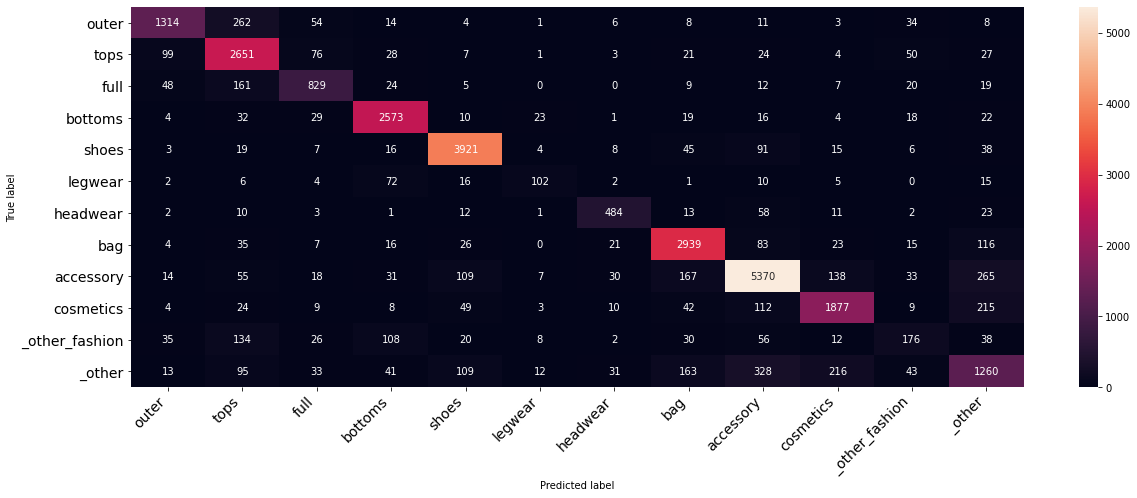

In [ ]:
## Loss and accuracy on test data
cnn_model.load_weights("best_cnn_model.h5")
scores = cnn_model.evaluate(arr_test_images, y_enc_test, verbose=0)
print(f"Test Logloss: {round(scores[0],3)}")
print(f"Test Accuracy: {round(scores[1],3)}")

## confustion matrix
y_pred = cnn_model.predict_classes(arr_test_images, verbose=0)
y_test2 = np.argmax(y_enc_test, axis=1)
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

#### With Dropout

Test Logloss: 0.082
Test Accuracy: 0.834


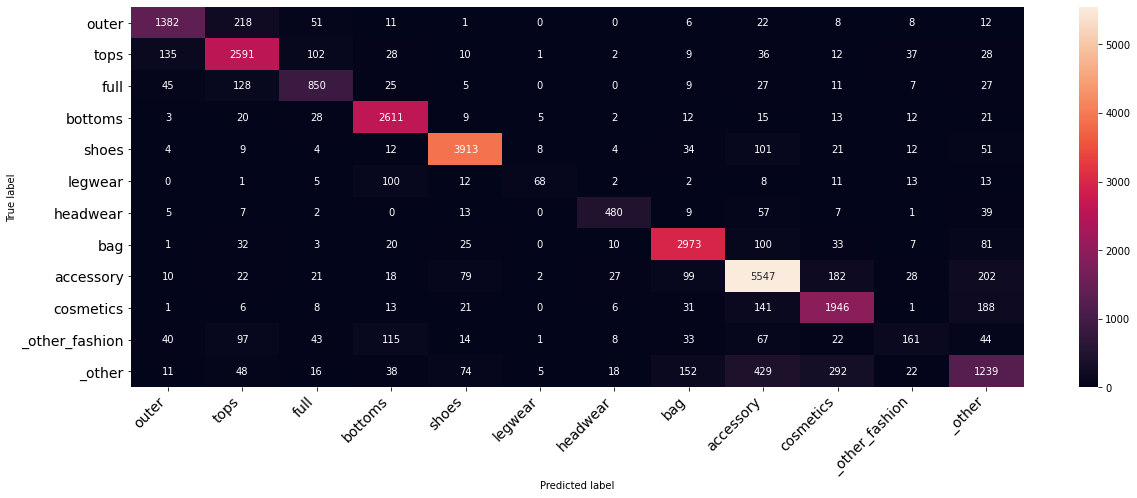

In [ ]:
## Loss and accuracy on test data
dropout_model.load_weights("best_model_dropout.h5")
scores = dropout_model.evaluate(arr_test_images, y_enc_test, verbose=0)
print(f"Test Logloss: {round(scores[0],3)}")
print(f"Test Accuracy: {round(scores[1],3)}")

## confustion matrix
y_pred = dropout_model.predict_classes(arr_test_images, verbose=0)
y_test2 = np.argmax(y_enc_test, axis=1)
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

<br><br><br>
<br><br><br>
<br><br><br>

## Layers Explanation
Explore and display a couple of layers preferably the first-Second-last  CNNs

summarize feature map size for each conv layer


##### Imports

In [ ]:
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot

from keras.models import Model
from matplotlib import pyplot as plt
from numpy import expand_dims

##### summarize feature map shapes


In [ ]:
for i in range(len(cnn_model.layers)):
	layer = cnn_model.layers[i]

	# check for convolutional layer
	if 'conv' not in layer.name:
		continue

	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d (None, 48, 48, 64)
3 conv2d_1 (None, 24, 24, 128)
6 conv2d_2 (None, 12, 12, 256)
9 conv2d_3 (None, 6, 6, 512)
12 conv2d_4 (None, 3, 3, 1024)


##### plot feature map of first conv layer for given image

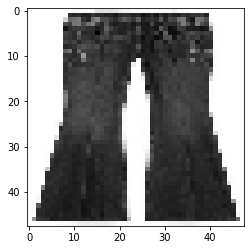

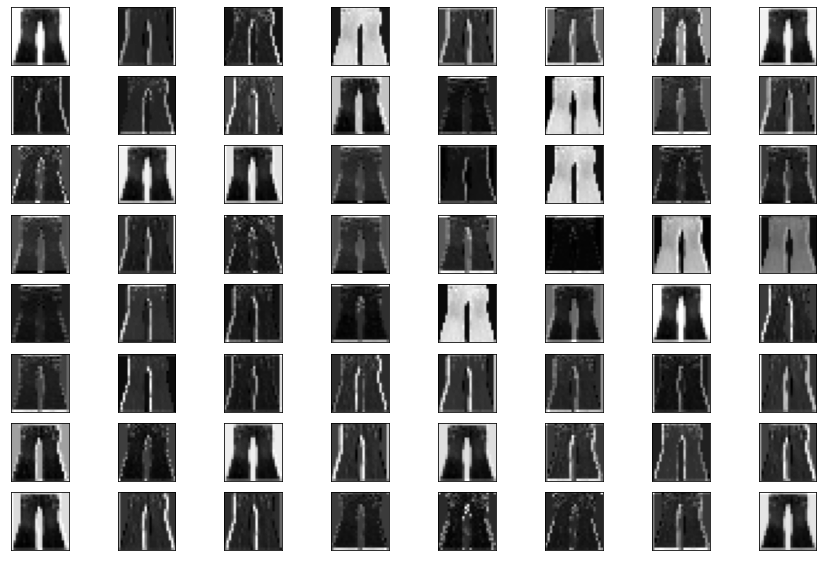

In [ ]:
model = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[1].output)

img = arr_train_images[2,:].reshape(1,48,48)
plt.figure()
plt.imshow(img.reshape(48,48), cmap='gray')
plt.show()
;

feature_maps = model.predict(img, verbose=0)

# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(15,10))
square = 8
ix = 1


for _ in range(square):
	for _ in range(square):

		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])

		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1

# show the figure
plt.show();

<br><br><br>
<br><br><br>
<br><br><br>

## Comparison
Use **plots** to compare our advance approach's results to the results achieved in by the baseline and dropout implementation.

In [ ]:
results = pd.DataFrame(columns=['ModelType','Evaluation','Score'])
names  = ['CNN','CNN_with_Dropout']
models = [cnn_model, dropout_model]

for i,(n,m) in enumerate(zip(names,models)):
  if n == "Transfer Learning":
    # scores = transfer_learning_model.evaluate(arr_stacked_test, y_enc_test, verbose=0)
    eval_train = round(m.evaluate(arr_stacked_train, y_enc_train, verbose=0)[1],3)
    eval_valid = round(m.evaluate(arr_stacked_valid, y_enc_valid, verbose=0)[1], 3)
    eval_test = round(m.evaluate(arr_stacked_test, y_enc_test, verbose=0)[1], 3)
  else:
    eval_train = round(m.evaluate(arr_train_images, y_enc_train, verbose=0)[1],3)
    eval_valid = round(m.evaluate(arr_valid_images, y_enc_valid, verbose=0)[1], 3)
    eval_test = round(m.evaluate(arr_test_images, y_enc_test, verbose=0)[1], 3)

  results.loc[len(results),:] = n,'Train',eval_train
  results.loc[len(results),:] = n,'Valid',eval_valid
  results.loc[len(results),:] = n,'Test',eval_test
print(results)

          ModelType Evaluation  Score
0               CNN      Train  0.983
1               CNN      Valid  0.822
2               CNN       Test  0.825
3  CNN_with_Dropout      Train   0.94
4  CNN_with_Dropout      Valid   0.83
5  CNN_with_Dropout       Test  0.834


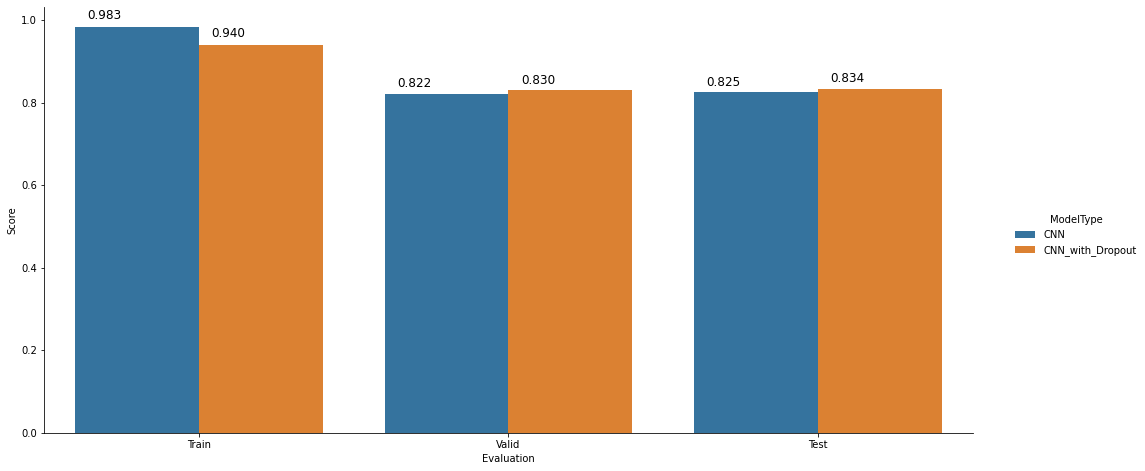

In [ ]:
g = sns.catplot(x="Evaluation", y="Score",
                hue="ModelType",
                data=results, kind="bar",
                height=7, aspect=2,saturation=0.7);


g.fig.subplots_adjust(top=0.9,right=0.85) 
sns.set_style("dark")
ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x()+0.04, 
            p.get_height() * 1.02, 
           '{0:.3f}'.format(p.get_height()), 
            color='black', 
            rotation='horizontal', 
            size='large')

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>